# Proyecto Series de Tiempo Univariadas
El siguiente Script abarca las metodologías vistas en el semestre 2024-1 de Series de Tiempo Univariadas desarrolladas en Python, utilizando la medición de la tasa de desempleo en Colombia; desde enero de 2001 hasta diciembre de 2023.

#### Integrantes: Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [102]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [103]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pylab as plt
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import scipy.stats 

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Importación base de datos

In [104]:
import os
os.chdir(r"C:\Users\EQUIPO\Documents")
os.getcwd()

'C:\\Users\\EQUIPO\\Documents'

In [105]:
Data = pd.read_excel("Base_de_datos_Parcial.xlsx",skiprows=12,nrows=282)
Data = Data.iloc[:,[0,5]]
print(Data.dtypes)
# Cambiar los nombres de las columnas
nuevos_nombres = ['Date', 'Value']
Data.columns = nuevos_nombres
Data
regresoras = pd.read_csv('Regresoras.csv')
regresoras = regresoras.iloc[12:]
regresoras = regresoras.reset_index(drop=True)
index = pd.date_range(start='2002-01-01', end='2024-06-01', freq='MS')
regresoras.index = index

2000 Dec       object
Unnamed: 5    float64
dtype: object


,Date,Value
0,2001 Jan,57.575237
1,2001 Feb,56.928209
2,2001 Mar,57.574460
3,2001 Apr,55.756693
4,2001 May,56.225804
...,...,...
277,2024 Feb,56.362688
278,2024 Mar,56.678326
279,2024 Apr,57.157354
280,2024 May,57.502190


## Gráfica de la tasa de desempleo en Colombia

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


C:\Users\EQUIPO\AppData\Local\Temp\ipykernel_9268\2700638135.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Data['Date']=pd.to_datetime(Data['Date'])#Convirtiendo la columna año y mes a formato fecha


Text(0.5, 1.0, 'Tasa de desempleo mensual en Colombia')

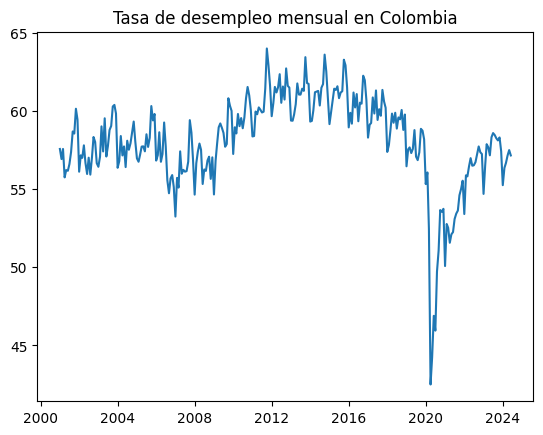

In [106]:
#Primera observación de los datos
Data['Date']=pd.to_datetime(Data['Date'])#Convirtiendo la columna año y mes a formato fecha
Data1=Data.set_index('Date')#Ordenando el dataframe, pero creo uno nuevo para volverlo objeto de series de tiempo luego
print(type(Data1))
#Convirtiendo el data frame en objeto serie de tiempo
TS=Data1['Value']
print(type(TS))
plt.plot(TS)#Haciendo un primer gráfico de la serie de tiempo
plt.title('Tasa de desempleo mensual en Colombia') 

Siguiendo el análisis descriptivo de R, no se realizará transformación de Box-Cox para estabilizar la varianza.

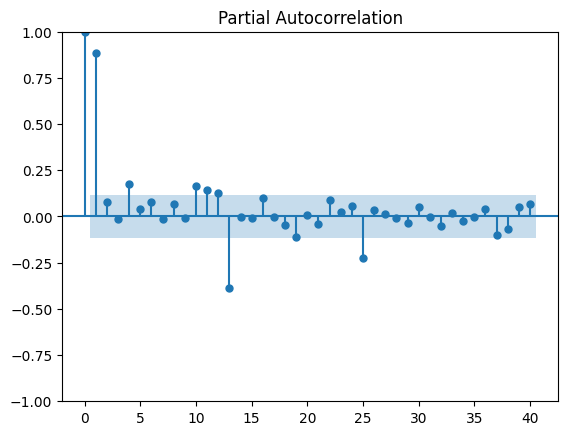

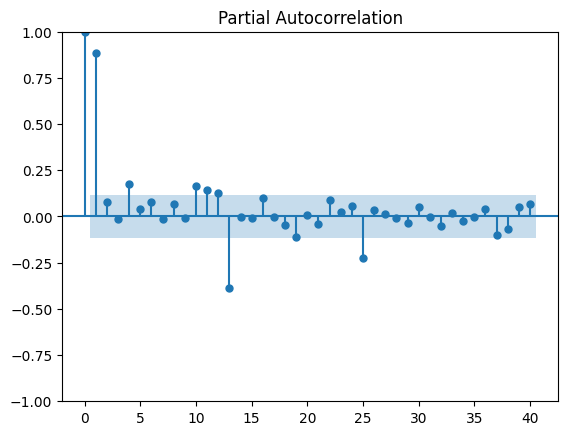

In [107]:
plot_pacf(TS, lags=40,method='ldbiased')
plt.show()

Aunque no todos los retardos parecen significativos, se utilizarán todos hasta el 12.

# Agregando componentes de Fourier

In [108]:
day = 24*60*60
year = (365.2425)*day

AnioyMes = Data['Date']
AnioyMes = AnioyMes.map(pd.Timestamp.timestamp) ###Convierte las fechas a float
Data['AnioSin'] = np.sin(AnioyMes * (2 * np.pi / year))
Data['AnioCos'] = np.cos(AnioyMes * (2 * np.pi / year))
Data

,Date,Value,AnioSin,AnioCos
0,2001-01-01,57.575237,0.008300,0.999966
1,2001-02-01,56.928209,0.515496,0.856892
2,2001-03-01,57.574460,0.853812,0.520582
3,2001-04-01,55.756693,0.999899,0.014246
4,2001-05-01,56.225804,0.876700,-0.481037
...,...,...,...,...
277,2024-02-01,56.362688,0.506958,0.861971
278,2024-03-01,56.678326,0.857573,0.514362
279,2024-04-01,57.157354,0.999976,0.006978
280,2024-05-01,57.502190,0.873181,-0.487396


# Modelamiento utilizando Redes Neuronales
## Redes Neuronales Multicapa(MLP)


In [109]:
NuevaConf = pd.DataFrame(Data['Value'].iloc[::-1].values,index=pd.date_range(start='2001-01-01', end='2024-6-01', freq='MS') )
from pandas import DataFrame
df2 = DataFrame()#Creando un DataFrame vacío para luego llenar
for i in range(12,0,-1):
    df2[['t-'+str(i)]] = NuevaConf.shift(i)#El método shift() se encarga de desplazar las filas i veces hacia abajo
    
#for i in range(6,1,-1):   

Estacionalidad = "dummy" # dummy para estacionalidad dummy, fourier para componentes de tipo fourier, otra cosa para no hacer ninguno de estos 2

if Estacionalidad == "dummy":
    
    df2.reset_index(inplace=True)
    df2.rename(columns={'index': 'Fecha'}, inplace=True)
    df2['Fecha']=pd.to_datetime(df2['Fecha'])  

    meses = {
        2: 'Febrero',
        3: 'Marzo',
        4: 'Abril',
        5: 'Mayo',
        6: 'Junio',
        7: 'Julio',
        8: 'Agosto',
        9: 'Septiembre',
        10: 'Octubre',
        11: 'Noviembre',
        12: 'Diciembre'
    }

    df2['Mes'] = df2['Fecha'].dt.month
    dummies = pd.get_dummies(df2['Mes'], prefix='Mes', drop_first=True).astype(int)  # drop_first=True para evitar la multicolinealidad
    df2 = df2.join(dummies)   
    
    column_mapping = {f'Mes_{num}': name for num, name in meses.items()}
    df2.rename(columns=column_mapping, inplace=True)
    
    df2.set_index('Fecha', inplace=True)

elif Estacionalidad == "fourier":
    
    NuevaConf2 = pd.DataFrame(Data[['AnioSin','AnioCos']].values,index=pd.date_range(start='2001-01-01', end='2024-06-01', freq='MS') )
    df2[['Sin','Cos']] = NuevaConf2.values



# Mostrar las primeras filas para verificar el cambio

df2 = df2[:-1]
regresoras = regresoras[:-1]
df2 = pd.concat([df2, regresoras], axis=1)
df2['t+1'] = NuevaConf.values[1:]
df2 = df2[12:]
print(df2.head(10))

                 t-12       t-11       t-10        t-9        t-8        t-7  \
2002-01-01  57.160909  57.502190  57.157354  56.678326  56.362688  55.256829   
2002-02-01  57.502190  57.157354  56.678326  56.362688  55.256829  57.434633   
2002-03-01  57.157354  56.678326  56.362688  55.256829  57.434633  58.311301   
2002-04-01  56.678326  56.362688  55.256829  57.434633  58.311301  58.122122   
2002-05-01  56.362688  55.256829  57.434633  58.311301  58.122122  58.254995   
2002-06-01  55.256829  57.434633  58.311301  58.122122  58.254995  58.465340   
2002-07-01  57.434633  58.311301  58.122122  58.254995  58.465340  58.591552   
2002-08-01  58.311301  58.122122  58.254995  58.465340  58.591552  58.324317   
2002-09-01  58.122122  58.254995  58.465340  58.591552  58.324317  57.168700   
2002-10-01  58.254995  58.465340  58.591552  58.324317  57.168700  57.679100   

                  t-6        t-5        t-4        t-3  ...  AO29  AO76  \
2002-01-01  57.434633  58.311301  58.122122 

Se utilizará desde el retardo 12 hasta el retardo anterior a t debido a experiencia previa, pues trabajando con la serie del desempleo, que es la de nuestro proyecto y que realmente en comportamiento es muy parecida a esta serie de tasa de ocupación; al eliminar algunos retardos, la red neuronal no se comportaba bien. Sin embargo, nuestra variable respuesta es **t+1**, por lo que estaremos haciendo la predicción dos pasos adelante.

Además se utilizarán variables dummy para modelar la estacionalidad porque con Fourier el modelo no ajustaba ni siquiera.

## División entrenamiento y prueba

In [110]:
fecha_inicio_val = '2022-01-01'  # Fecha de inicio del conjunto de validación
fecha_inicio_test = '2023-01-01'  # Fecha de inicio del conjunto de prueba

# Dividir el DataFrame en entrenamiento, validación y prueba
train_feature = df2[df2.index <= '2021-12-01']  
val_feature = df2[(df2.index >= '2022-01-01') & (df2.index <= '2022-12-01')]  
train_feature_full = df2[df2.index <= '2022-12-01'] 
test_feature = df2[(df2.index >= '2023-01-01') & (df2.index <= '2023-12-01')]

In [111]:
print(train_feature)

                 t-12       t-11       t-10        t-9        t-8        t-7  \
2002-01-01  57.160909  57.502190  57.157354  56.678326  56.362688  55.256829   
2002-02-01  57.502190  57.157354  56.678326  56.362688  55.256829  57.434633   
2002-03-01  57.157354  56.678326  56.362688  55.256829  57.434633  58.311301   
2002-04-01  56.678326  56.362688  55.256829  57.434633  58.311301  58.122122   
2002-05-01  56.362688  55.256829  57.434633  58.311301  58.122122  58.254995   
...               ...        ...        ...        ...        ...        ...   
2021-08-01  59.329464  58.604887  57.937423  57.524291  58.101888  56.414921   
2021-09-01  58.604887  57.937423  57.524291  58.101888  56.414921  57.736975   
2021-10-01  57.937423  57.524291  58.101888  56.414921  57.736975  57.160189   
2021-11-01  57.524291  58.101888  56.414921  57.736975  57.160189  58.402600   
2021-12-01  58.101888  56.414921  57.736975  57.160189  58.402600  56.797085   

                  t-6        t-5       

In [112]:
print(val_feature)

                 t-12       t-11       t-10        t-9        t-8        t-7  \
2022-01-01  56.414921  57.736975  57.160189  58.402600  56.797085  56.369651   
2022-02-01  57.736975  57.160189  58.402600  56.797085  56.369651  59.843455   
2022-03-01  57.160189  58.402600  56.797085  56.369651  59.843455  60.395304   
2022-04-01  58.402600  56.797085  56.369651  59.843455  60.395304  60.293066   
2022-05-01  56.797085  56.369651  59.843455  60.395304  60.293066  59.047631   
2022-06-01  56.369651  59.843455  60.395304  60.293066  59.047631  58.791977   
2022-07-01  59.843455  60.395304  60.293066  59.047631  58.791977  57.768326   
2022-08-01  60.395304  60.293066  59.047631  58.791977  57.768326  57.092651   
2022-09-01  60.293066  59.047631  58.791977  57.768326  57.092651  59.538093   
2022-10-01  59.047631  58.791977  57.768326  57.092651  59.538093  57.415488   
2022-11-01  58.791977  57.768326  57.092651  59.538093  57.415488  59.020967   
2022-12-01  57.768326  57.092651  59.538

In [113]:
print(train_feature_full)

                 t-12       t-11       t-10        t-9        t-8        t-7  \
2002-01-01  57.160909  57.502190  57.157354  56.678326  56.362688  55.256829   
2002-02-01  57.502190  57.157354  56.678326  56.362688  55.256829  57.434633   
2002-03-01  57.157354  56.678326  56.362688  55.256829  57.434633  58.311301   
2002-04-01  56.678326  56.362688  55.256829  57.434633  58.311301  58.122122   
2002-05-01  56.362688  55.256829  57.434633  58.311301  58.122122  58.254995   
...               ...        ...        ...        ...        ...        ...   
2022-08-01  60.395304  60.293066  59.047631  58.791977  57.768326  57.092651   
2022-09-01  60.293066  59.047631  58.791977  57.768326  57.092651  59.538093   
2022-10-01  59.047631  58.791977  57.768326  57.092651  59.538093  57.415488   
2022-11-01  58.791977  57.768326  57.092651  59.538093  57.415488  59.020967   
2022-12-01  57.768326  57.092651  59.538093  57.415488  59.020967  57.080815   

                  t-6        t-5       

In [114]:
print(test_feature)

                 t-12       t-11       t-10        t-9        t-8        t-7  \
2023-01-01  57.092651  59.538093  57.415488  59.020967  57.080815  56.433797   
2023-02-01  59.538093  57.415488  59.020967  57.080815  56.433797  56.665447   
2023-03-01  57.415488  59.020967  57.080815  56.433797  56.665447  58.019693   
2023-04-01  59.020967  57.080815  56.433797  56.665447  58.019693  58.341028   
2023-05-01  57.080815  56.433797  56.665447  58.019693  58.341028  57.023163   
2023-06-01  56.433797  56.665447  58.019693  58.341028  57.023163  55.932460   
2023-07-01  56.665447  58.019693  58.341028  57.023163  55.932460  57.016176   
2023-08-01  58.019693  58.341028  57.023163  55.932460  57.016176  55.974103   
2023-09-01  58.341028  57.023163  55.932460  57.016176  55.974103  56.680111   
2023-10-01  57.023163  55.932460  57.016176  55.974103  56.680111  57.806830   
2023-11-01  55.932460  57.016176  55.974103  56.680111  57.806830  57.006099   
2023-12-01  57.016176  55.974103  56.680

In [115]:
X_train_full = train_feature_full.values[:, 0:-1]
y_train_full = train_feature_full.values[:,-1]

X_test = test_feature.values[:, 0:-1]
y_test = test_feature.values[:,-1]

X_train = train_feature.values[:, 0:-1]
y_train = train_feature.values[:,-1]

X_val = val_feature.values[:, 0:-1]
y_val = val_feature.values[:,-1]

type(X_val)

numpy.ndarray

División del entrenamiento en entrenamiento y validación (el tamaño de los conjuntos fue dado por el enunciado).

### Estandarización de las covariables

Esto para ayudar a la convergencia de los métodos

In [116]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

Las respuestas no se estandarizan

In [117]:
import random

In [118]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=8, max_value=32, step=24),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=8, max_value=32, step=24),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2,step=0.003)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

<Sequential name=sequential_2, built=False>

### Búsqueda de los hiperparámetros utilizando Grid Search

In [119]:
tuner_GridSearch_mlp = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=None,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [120]:
tuner_GridSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 24, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 24, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': 0.003, 'sampling': 'linear'}


In [121]:
stop_early=keras.callbacks.EarlyStopping(monitor="val_loss",patience=2)

In [122]:
random.seed(123)
tuner_GridSearch_mlp.search(X_train,y_train, batch_size = 10, epochs=50, validation_data=(X_val,y_val),callbacks=[stop_early])

Trial 240 Complete [00h 00m 07s]
val_loss: 1.2145267724990845

Best val_loss So Far: 1.209227442741394
Total elapsed time: 00h 26m 46s


In [123]:
# Get the top 2 models.
models_mlp = tuner_GridSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
# best_model_mlp.build(input_shape=(32, 1, 7))
best_model_mlp.summary()

C:\Users\EQUIPO\anaconda3\envs\SeriesDeTiempo\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (10, 32)               │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (10, 8)                │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (10, 32)               │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (10, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (10, 1)                │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,673 (6.54 KB)

 Trainable params: 1,673 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Los mejores 10 modelos

In [124]:
tuner_GridSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0221 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 8
dropout: True
lr: 0.007
units_1: 32
Score: 1.209227442741394

Trial 0215 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 8
dropout: False
lr: 0.010000000000000002
units_1: 32
Score: 1.2092351913452148

Trial 0111 summary
Hyperparameters:
num_units: 8
activation: tanh
num_layers: 2
units_0: 32
dropout: True
lr: 0.010000000000000002
units_1: 32
Score: 1.2092400789260864

Trial 0235 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 32
dropout: True
lr: 0.004
units_1: 32
Score: 1.2092481851577759

Trial 0219 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 2
units_0: 8
dropout: True
lr: 0.004
units_1: 32
Score: 1.209267020225525

Trial 0205 summary
Hyperparameters:
num_units: 32
activation: tanh
num_layers: 

### Modelo final
Finalmente se entrenará el mejor modelo con los datos de entrenamiento y validación.

In [125]:
callback=keras.callbacks.EarlyStopping(monitor="loss",patience=5)
best_hps_mlp = tuner_GridSearch_mlp.get_best_hyperparameters(2)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(X_train_full,y_train_full,batch_size = 10, epochs=50 ,callbacks=[callback])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 3051.2412 - mean_squared_error: 3051.2410 
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 2129.9417 - mean_squared_error: 2129.9417
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 1583.4940 - mean_squared_error: 1583.4940
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 1132.0178 - mean_squared_error: 1132.0178
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 827.3132 - mean_squared_error: 827.3132
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 552.3810 - mean_squared_error: 552.3810
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 377.1598 - mean_squared_error: 377.1598
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 302.1365 - mean_squared_error: 302.1365
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 178.8042 - mean_squared_error: 178.8042
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 157.2910 - mean_squared_error:

In [126]:
model_mlp.layers[0].get_weights()[0]

array([[-0.22904658,  0.01379639, -0.02883208, ...,  0.0747937 ,
         0.3295087 , -0.09986164],
       [-0.14541963,  0.06617332,  0.27732843, ..., -0.13073915,
         0.2578851 ,  0.01531296],
       [ 0.24999122,  0.25559807,  0.02212155, ...,  0.02754089,
         0.21461834,  0.03761269],
       ...,
       [-0.09269563, -0.18810907,  0.00448477, ...,  0.03247535,
         0.10156191,  0.10452747],
       [ 0.05371294,  0.15842426, -0.01412168, ...,  0.14788043,
         0.16639568,  0.22164685],
       [ 0.28068116, -0.27267703,  0.07877564, ..., -0.20018508,
         0.07752046, -0.22983453]], dtype=float32)

In [127]:
print(model_mlp.layers[0].bias.numpy())

[ 0.05083509  0.          0.          0.         -0.02958174  0.04203159
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.04184748  0.          0.          0.
  0.          0.         -0.00753418  0.          0.00121335  0.
  0.04520444  0.          0.05603614  0.          0.          0.
  0.05203564 -0.01069565]


In [128]:
X_test.shape

(12, 33)

In [129]:
prediction_test=model_mlp.predict( X_test, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [130]:
y_test=y_test.reshape((y_test.shape[0], 1))

In [131]:
errors_squared=keras.metrics.MeanSquaredError()
errors_squared.update_state(y_test, prediction_test)
print("ECM:",errors_squared.result().numpy())

ECM: 1.5668602


Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

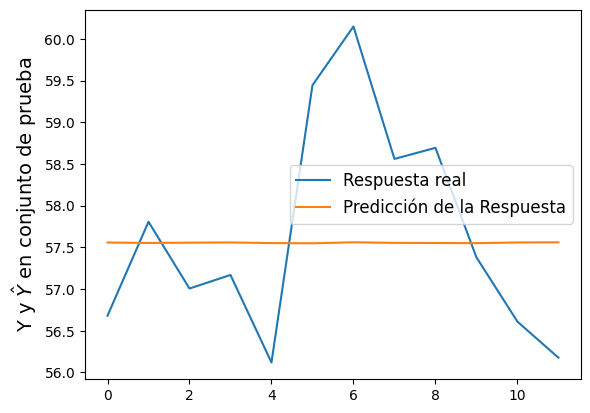

In [132]:
plt.plot(y_test)
plt.plot(prediction_test)
plt.legend(['Respuesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)

Text(0, 0.5, '$\\hat{e}$ en conjunto de prueba')

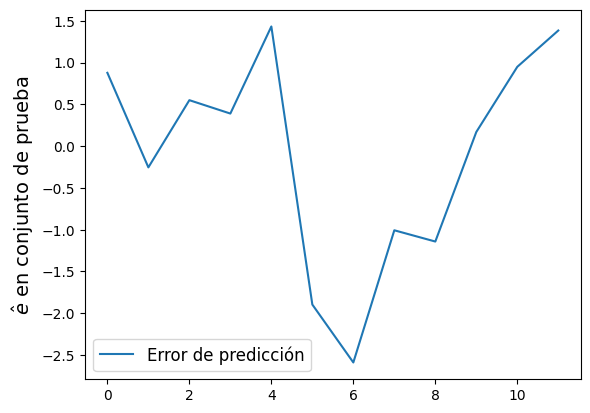

In [133]:
#Gráfico de errores
plt.plot(prediction_test-y_test)
plt.legend(['Error de predicción'],loc="best", fontsize=12)
plt.ylabel('$\hat{e}$ en conjunto de prueba', fontsize=14)

In [134]:
X = np.concatenate((X_train, X_val,X_test))
y_test = y_test.ravel()  
y = np.concatenate((y_train, y_val, y_test))

In [135]:
print(X.shape)
print(y.shape)

(264, 33)
(264,)


In [136]:
predictions=model_mlp.predict(X, verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


In [137]:
residuales=y-predictions
residuales = residuales.ravel()
residuales

array([-0.38282512,  0.12757488,  0.32857488, ..., -0.17943407,
       -0.95133143, -1.38404148])

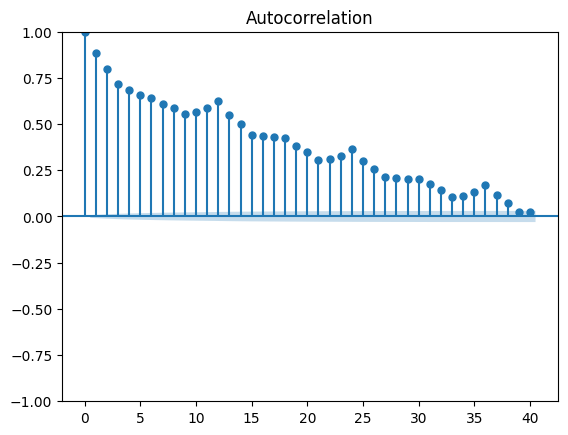

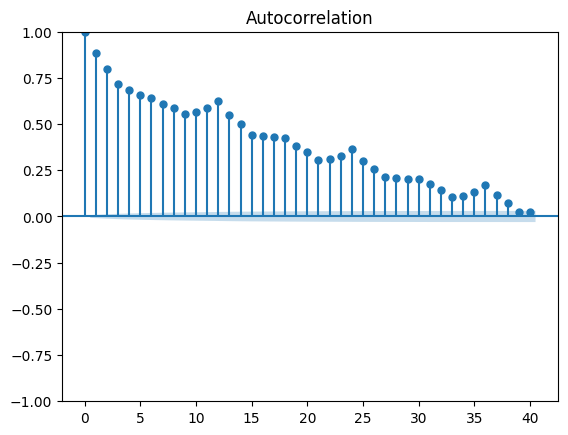

In [37]:
plot_acf(residuales, lags=40)
plt.show()

Aunque el ECM no es tan alto y se pusieron como variables regresoras los outliers, se ve que el modelo de redes no captura el comportamiento de la serie, además los residuales no parecen ser normales, sigue habiendo una correlación muy grande, por lo que este modelo no se usará.